In [18]:
# Python 3.10
# Import packages, inline matplot

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import eli5
import re
import os

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc,log_loss, confusion_matrix



%matplotlib inline

In [19]:
# Load in the data
plays = pd.read_csv(os.path.join(os.path.abspath(''),'data\\game_plays.csv'), index_col=0)
player_info = pd.read_csv(os.path.join(os.path.abspath(''),'data\\player_info.csv'), index_col=0)
skater_stats = pd.read_csv(os.path.join(os.path.abspath(''),'data\\game_skater_stats.csv'))
team_data = pd.read_csv(os.path.join(os.path.abspath(''),"data\\game_teams_stats.csv"), index_col=0)
team_meta_data = pd.read_csv(os.path.join(os.path.abspath(''),"data\\team_info.csv"), index_col=0)
teams = team_meta_data.merge(team_data, on='team_id')
game_data = pd.read_csv(os.path.join(os.path.abspath(''),"data\\game.csv"), index_col=0)

In [20]:
# Delete unnessary columns, delete rows that dont have data or are duplicates

# Drop unnecessary columns
team_data = team_data.drop(['goals',"powerPlayGoals","startRinkSide"], axis=1)
team_data.sort_index(axis=0, inplace=True)

# Split home and away stats
splitter = team_data.HoA == "home"
home_data = team_data[splitter]
away_data = team_data[~splitter]

# Dont need redundant data, drop unecessary columns in home data that will be represented in away data
home_data = home_data.drop(["won", "settled_in", "faceOffWinPercentage"], axis=1)
# Prefix the columns
home_data = home_data.add_prefix("home_")
away_data = away_data.add_prefix("away_")
# Concat DF's on index, so we have away and home stats per game
team_data = pd.concat([away_data, home_data], axis=1)
team_data = team_data.drop(['away_HoA', "home_HoA"], axis=1)

data_length = len(team_data.index)
# Faceoff percentage is an important stat, it offers puck possesion which I believe is key for victory
# Drop all games missing this faceoff stat
team_data = team_data[~team_data.away_faceOffWinPercentage.isnull()]
# Drop games that are to be continued due to delays or emergency stops
team_data = team_data[~(team_data.away_settled_in == "tbc")]
# Remove duplicate data
team_data = team_data[~team_data.index.duplicated()]
# These teams are not current within the NHL
team_data = team_data[~(team_data['away_team_id'].isin([87,88,89,90]))]
data_length = data_length - len(team_data.index)
print("Dropped ",data_length," Rows From Team Data")


Dropped  13659  Rows From Team Data


Top Rated Players according to weight factors:
          firstName  lastName     score
player_id                              
8471214        Alex  Ovechkin  6.314256
8455738       Pavel      Bure  5.785714
8459021       Chris   Ferraro  5.500000
8467957        Brad      Fast  5.500000
8448782       Mario   Lemieux  5.426471


Team Weighted Score Per Game
      game_id  team_id     score
0  2000020001       21  2.205729
1  2000020001       25  2.132564
2  2000020002        6  1.973760
3  2000020002        9  2.547927
4  2000020003        7  1.965341
       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192020            52   

C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()


       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192020            52          2.248317
301  20192020            53          2.515476
302  20192020            54          2.390061

[303 rows x 3 columns]
       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192

C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()
C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()


       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192020            52          2.248317
301  20192020            53          2.515476
302  20192020            54          2.390061

[303 rows x 3 columns]
       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192

C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()
C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()


       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192020            52          2.248317
301  20192020            53          2.515476
302  20192020            54          2.390061

[303 rows x 3 columns]
       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192

C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()
C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()


       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192020            52          2.248317
301  20192020            53          2.515476
302  20192020            54          2.390061

[303 rows x 3 columns]
       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192

C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()
C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()


       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192020            52          2.248317
301  20192020            53          2.515476
302  20192020            54          2.390061

[303 rows x 3 columns]
       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192

C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()
C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()
C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()
C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()


       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192020            52          2.248317
301  20192020            53          2.515476
302  20192020            54          2.390061

[303 rows x 3 columns]
       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192

C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()
C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()


       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192020            52          2.248317
301  20192020            53          2.515476
302  20192020            54          2.390061

[303 rows x 3 columns]
       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192

C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()
C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()


       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192020            52          2.248317
301  20192020            53          2.515476
302  20192020            54          2.390061

[303 rows x 3 columns]
       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192

C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()


       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192020            52          2.248317
301  20192020            53          2.515476
302  20192020            54          2.390061

[303 rows x 3 columns]
       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192

C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()
C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()
C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()


       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192020            52          2.248317
301  20192020            53          2.515476
302  20192020            54          2.390061

[303 rows x 3 columns]
       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192

C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()


       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192020            52          2.248317
301  20192020            53          2.515476
302  20192020            54          2.390061

[303 rows x 3 columns]
       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192

C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()
C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()


       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192020            52          2.248317
301  20192020            53          2.515476
302  20192020            54          2.390061

[303 rows x 3 columns]
       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192

C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()
C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()
C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()


       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192020            52          2.248317
301  20192020            53          2.515476
302  20192020            54          2.390061

[303 rows x 3 columns]
       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192

C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()
C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()


       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192020            52          2.248317
301  20192020            53          2.515476
302  20192020            54          2.390061

[303 rows x 3 columns]
       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192

C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()
C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()


       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192020            52          2.248317
301  20192020            53          2.515476
302  20192020            54          2.390061

[303 rows x 3 columns]
       season  away_team_id  away_team_weight
0    20102011             1          2.122451
1    20102011             2          2.063217
2    20102011             3          2.251695
3    20102011             4          2.392105
4    20102011             5          2.208307
..        ...           ...               ...
298  20192020            29          2.299004
299  20192020            30          2.542010
300  20192

C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()
C:\Users\josh_\AppData\Local\Temp\ipykernel_4204\667054109.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()


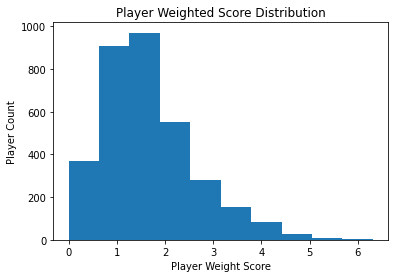

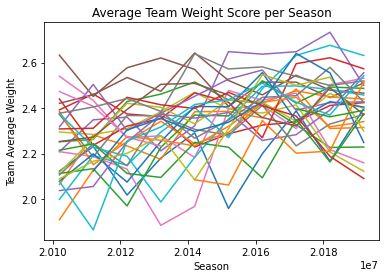

In [21]:
# Add feature team weight
# Accumalate a team score of competitiveness (rate the team with the players playing)

# Weighted factors that will rate a player by their skill
weighted_factors = {
    'points' : 1.5,
    'shots' : 1,
    'blocked' : 1.3,
    'takeaways': 5.0,
    'giveaways' : -5,
    'plusMinus' : 1.5,
    'penaltyMinutes': -0.01,
    'hits': 1
}

# Add column to be populated later
skater_stats['games'] = ""

# Group by player id to get the players totals since the year 2000 
players_totals = skater_stats.groupby('player_id').agg({
     'games': 'count',
     'goals':'sum',
     'assists' : 'sum',
     'shots' : 'sum',
     'hits' : 'sum',
     'penaltyMinutes' : 'sum',
     'blocked' : 'sum',
     'plusMinus' : 'sum',
     'takeaways' : 'sum',
     'giveaways' : 'sum'})

# Add column of player's total points
players_totals['points'] = players_totals['goals'] + players_totals['assists']

# Get player averages and add them as seperate colums with applying weighted factors
players_totals['pointsPerGame'] = (players_totals['points'] / players_totals['games']) * weighted_factors['points']
players_totals['shotsPerGame'] = (players_totals['shots'] / players_totals['games']) * weighted_factors['shots']
players_totals['blocksPerGame'] = (players_totals['blocked'] / players_totals['games']) * weighted_factors['blocked']
players_totals['takeawaysPerGame'] = (players_totals['takeaways'] / players_totals['games']) * weighted_factors['takeaways']
players_totals['giveawaysPerGame'] = (players_totals['giveaways'] / players_totals['games']) * weighted_factors['giveaways']
players_totals['plusMinusPerGame'] = (players_totals['plusMinus'] / players_totals['games']) * weighted_factors['plusMinus']
players_totals['penaltyMinutesPerGame'] = (players_totals['penaltyMinutes'] / players_totals['games']) * weighted_factors['penaltyMinutes']
players_totals['hitsPerGame'] = (players_totals['hits'] / players_totals['games']) * weighted_factors['hits']

# Get each players total score
players_totals['score'] = players_totals['pointsPerGame'] + players_totals['shotsPerGame']
+ players_totals['blocksPerGame'] + players_totals['takeawaysPerGame'] + players_totals['giveawaysPerGame']
+ players_totals['plusMinusPerGame'] + players_totals['penaltyMinutesPerGame'] + players_totals['hitsPerGame']

# Sort player score, see who is on top
players_totals = players_totals.merge(player_info, on='player_id', how='left').sort_values(by='score', ascending=False)

print("Top Rated Players according to weight factors:")
print(players_totals.loc[:,['firstName','lastName','score']].head())

# Plot average player score
plt.figure()
plt.hist(players_totals['score'])
plt.title("Player Weighted Score Distribution")
plt.xlabel("Player Weight Score")
plt.ylabel("Player Count")

# Apply team weights for each game played
player_weights = skater_stats.merge(players_totals['score'], on='player_id', how='left')
team_weights = player_weights.groupby(['game_id','team_id'], as_index=False).agg({'score' : 'mean'})

# Show team weight per game
print("\n\nTeam Weighted Score Per Game")
print(team_weights.head())

# Add weights to each game for away team and home team
team_data = team_data.reset_index()
team_data = team_data.merge(team_weights.rename(columns= {'team_id' : 'away_team_id', 'score': 'away_team_weight'}))
team_data = team_data.merge(team_weights.rename(columns= {'team_id' : 'home_team_id', 'score': 'home_team_weight'}))

team_weights_avg = team_data.merge(game_data['season'], on='game_id', how='left').groupby(['season', 'away_team_id'], as_index=False).agg({'away_team_weight': 'mean'})

teams = team_weights_avg['away_team_id'].unique().tolist()

# Plot the average team weight per team per season
# Pretty cool data, that is considered significant
plt.figure()
for teamid in teams:
    seasons = team_weights_avg[team_weights_avg.away_team_id == teamid]['season'].tolist()  
    print(team_weights_avg)
    weights = [] 
    for season in seasons:
        weight = team_weights_avg[team_weights_avg.season == season]
        weight = weight[team_weights_avg.away_team_id == teamid]['away_team_weight'].tolist()
        
        weight = weight.pop()
        weights.append(weight)        
    plt.plot(seasons, weights)


plt.title("Average Team Weight Score per Season")
plt.ylabel("Team Average Weight")
plt.xlabel("Season")

# Assign data var
data = team_data

# Collect categorical variables
categorical = [name for name in data.columns if data[name].dtype == 'object']
categorical = categorical

# Collect numeric variables
numeric = [column for column in data.columns if column not in categorical]

# This is the y value, remove from X
if "away_won" in numeric: numeric.remove("away_won")

2145
3722
6137
11726
23730


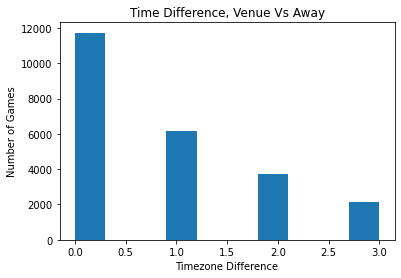

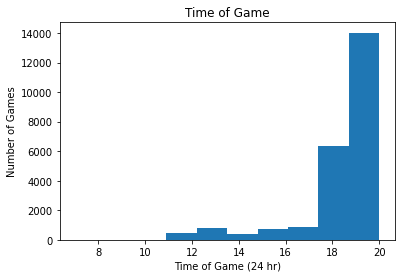

In [22]:
# Add feature timechange and time
# The time difference from the venue and away team, could impact player fatigue (Ex. jetlag)

game_data = game_data[~game_data.index.duplicated()]
game_data = game_data[~(game_data['away_team_id'].isin([87,88,89,90]))]
# Readjust the timezones (exclude daylight savings)
def timezone_change(tz):
    res = re.search("[A-Z]DT", tz)
    if res != None:
        return 1
    else:
        return 0

# Find the offset of the daylight savings timezones
offset = game_data.venue_time_zone_tz.apply(timezone_change)

# Adjust the venue time zone due to daylight savings
game_data.venue_time_zone_offset = (game_data.venue_time_zone_offset - offset)

# Get the acutal time of game from datetime info
res = game_data.date_time_GMT.apply(lambda x: int(re.search("T(\d+):", x).group(1)))

# Add the time of the game in military time to DF
game_data['time'] = (res + game_data.venue_time_zone_offset) % 24

# Timezone mappings for all team IDs
timezones = {1:5, 4:5, 26:8, 14:5, 6:5, 3:5, 5:5, 17:5, 28:8, 18:6, 23:8, 16:6, 9:5,
             8:5, 30:6, 15:5, 19:6, 24:8, 27:7, 2:5, 10:5,13:5, 7:5, 20:7, 21:7, 25:6, 29:5, 52:6, 22:7, 54:8, 12:5, 53:7, 11:5}
# Away team timezones
game_data['timezone']  = -game_data.away_team_id.apply(lambda x: timezones[x])
# Calculate time difference between home team and away team
game_data['timechange'] = np.abs(game_data.timezone - game_data.venue_time_zone_offset)
print(len(game_data['timechange'].loc[game_data['timechange'] == 3]))
print(len(game_data['timechange'].loc[game_data['timechange'] == 2]))
print(len(game_data['timechange'].loc[game_data['timechange'] == 1]))
print(len(game_data['timechange'].loc[game_data['timechange'] == 0]))
print(len(game_data['timechange']))
# Plot the time difference in hours between venue and away team
plt.figure()
plt.hist(game_data['timechange'])
plt.title("Time Difference, Venue Vs Away")
plt.ylabel("Number of Games")
plt.xlabel("Timezone Difference")

# Plot the time of each game 
plt.figure()
plt.hist(game_data['time'])  
plt.title("Time of Game")
plt.ylabel("Number of Games")
plt.xlabel("Time of Game (24 hr)")

# Add these values to team_data
toAdd = game_data[['season','type','time','timechange']]

mask = toAdd.index.isin(team_data.index)
toAdd.drop(toAdd[mask].index)

# Assign data var
data = team_data.merge(toAdd, on="game_id", how="left")

# Collect categorical variables
categorical = [name for name in data.columns if data[name].dtype == 'object']
categorical = categorical + ["season", "time"]

# Collect numeric variables
numeric = [column for column in data.columns if column not in categorical]

# This is the y value, remove from X
if "away_won" in numeric: numeric.remove("away_won")

All Categories
['away_settled_in', 'away_head_coach', 'home_head_coach', 'type', 'season', 'time']
['game_id', 'away_team_id', 'away_shots', 'away_hits', 'away_pim', 'away_powerPlayOpportunities', 'away_faceOffWinPercentage', 'away_giveaways', 'away_takeaways', 'away_blocked', 'home_team_id', 'home_shots', 'home_hits', 'home_pim', 'home_powerPlayOpportunities', 'home_giveaways', 'home_takeaways', 'home_blocked', 'away_team_weight', 'home_team_weight', 'timechange']
Mean Cross Validation Area Under Curve Score: 0.743119296265353
tp: 5117 tn: 3710 fp: 1747 fn: 2072
Accuracy: 0.698 Recall: 0.712 Precision: 0.745 Sensitivity: 0.712 Specificity: 0.68
Log loss on training data:  10.281363502070027
Log loss on test data:  10.77869115143663


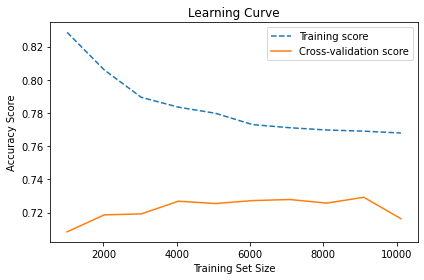

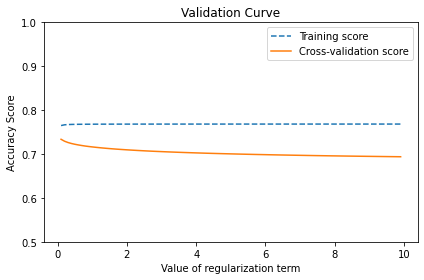

In [23]:
# Logistic Regression implementation

print("All Categories")
print(categorical)
print(numeric)

# set the preprocessing config
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(), categorical)])

# The results y
y = data.away_won
# The data X (features)
X = data.iloc[:,~data.columns.isin(['away_won'])]

# Transform data, categorical transform with one hot encoder, scale numeric values
X = preprocess.fit_transform(X)

# Train test split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

# Init classifier
LogReg = LogisticRegression(solver='newton-cg')

# Cross val with train data
cv_score = cross_val_score(LogReg, X_train, y_train, cv=5, scoring='roc_auc')

print(f"Mean Cross Validation Area Under Curve Score: {cv_score.mean()}")

# Fit classifier with training data
LogReg.fit(X_train, y_train)

# Get predictions
y_train_predict = LogReg.predict(X_train)
y_test_predict = LogReg.predict(X_test)

# Print results
cmTrain = confusion_matrix(y_train, y_train_predict)
cmTest = confusion_matrix(y_test, y_test_predict)
tp = cmTrain[0][0] + cmTest[0][0]
tn = cmTrain[1][1] + cmTest[1][1]
fp = cmTrain[0][1] + cmTest[0][1]
fn = cmTrain[1][0] + cmTest[1][0]

acc = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
sensitivity = recall
specificity = tn / (fp + tn)


print(f"tp: {tp} tn: {tn} fp: {fp} fn: {fn}")
print("Accuracy:",round(acc,3),"Recall:",round(recall,3),"Precision:",round(precision,3),
    "Sensitivity:",round(sensitivity,3),"Specificity:",round(specificity,3))

print("Log loss on training data: ",log_loss(y_train,y_train_predict))
print("Log loss on test data: ",log_loss(y_test,y_test_predict))  


# Produce learning curve
train_sizes, train_scores, test_scores = learning_curve(LogReg, X, y, cv=5, scoring ='roc_auc',
train_sizes=np.linspace(.1, 1.0, 10))

# Create mean of train and test scores
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Plot learning curve lines (mean of training and test scores)
plt.figure()
plt.plot(train_sizes, train_mean, '--',  label="Training score")
plt.plot(train_sizes, test_mean,  label="Cross-validation score")

# Add title and labels and show the plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Define the range of parameter to be tested
param_range = np.arange(0.1,10,0.1)
train_scores, test_scores = validation_curve(LogReg, X, y, param_name="C", param_range=param_range, cv=5, scoring="roc_auc")
# Calculate mean for training and test scores
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Plot validation curve lines (mean of training and test scores)
plt.figure()
plt.plot(param_range, train_mean, '--',label="Training score")
plt.plot(param_range, test_mean, label="Cross-validation score")

# Add title and labels and show the plot
plt.title("Validation Curve")
plt.ylim([0.5, 1.0])
plt.xlabel("Value of regularization term")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


  

All Categories
['away_settled_in', 'away_head_coach', 'home_head_coach', 'type', 'season', 'time']
['game_id', 'away_team_id', 'away_shots', 'away_hits', 'away_pim', 'away_powerPlayOpportunities', 'away_faceOffWinPercentage', 'away_giveaways', 'away_takeaways', 'away_blocked', 'home_team_id', 'home_shots', 'home_hits', 'home_pim', 'home_powerPlayOpportunities', 'home_giveaways', 'home_takeaways', 'home_blocked', 'away_team_weight', 'home_team_weight', 'timechange']
Number of Trees
50.0
75.0
100.0
125.0
150.0
175.0
200.0
225.0
250.0
275.0
300.0
325.0
350.0
375.0
400.0
425.0
450.0
475.0
500.0
525.0
550.0
Out Of Bag Error
[0.37031179394487124, 0.3529145955716222, 0.34410302756439226, 0.3411658382286489, 0.33845458653411653, 0.3364211477632173, 0.33540442837776774, 0.3326931766832354, 0.33065973791233616, 0.3297559873474921, 0.3303208314505196, 0.3308856755535472, 0.3315634884771803, 0.32885223678264797, 0.32806145503840944, 0.3265928603705377, 0.3270447356529598, 0.32749661093538185, 0.32

C:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Random Forest Area Under Curve Score : 0.7373257399737347


Text(0.5, 0, 'False Positive Rate')

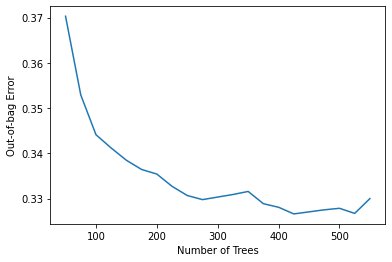

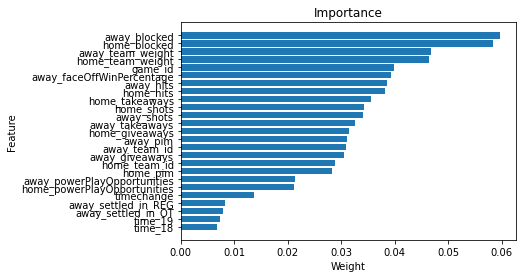

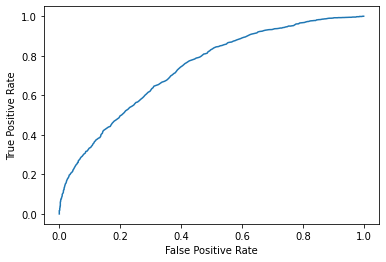

In [8]:
# Random Forest implementation

print("All Categories")
print(categorical)
print(numeric)

# set the preprocessing config
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(handle_unknown = "ignore"), categorical)])

# Result wanted, y
y = data.away_won
# The rest of features, X
X = data.iloc[:,~data.columns.isin(['away_won'])]

# Transform data, categorical transform with one hot encoder, scale numeric values
X = preprocess.fit_transform(X)

# Train test split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# number of tress to produce
numTrees = np.linspace(50,550, num=21)

# Init classifier
rf = RandomForestClassifier(oob_score=True, random_state=0, n_jobs=8)

error = []
print("Number of Trees")
# Iterate over number of trees
for i in range(len(numTrees)):
  print(numTrees[i])
  rf.set_params(n_estimators=int(numTrees[i]))
  rf.fit(X_train, y_train)
  oob_error = 1 - rf.oob_score_
  error.append(oob_error)

print("Out Of Bag Error")
print(error)

# Plot OOB error graph
plt.figure()
plt.plot(numTrees, error)
plt.ylabel("Out-of-bag Error")
plt.xlabel("Number of Trees")

# Evaluate model performance on the test data
y_rf_pred = rf.predict(X_test)
y_rf_pred_prob = rf.predict_proba(X_test)

# Grab all columns produced by One Hot Encoder
onehot_columns = list(preprocess.named_transformers_['cat'].get_feature_names(input_features=categorical))

# Find significant weights used in Tree
weights = eli5.explain_weights(rf, top=25, feature_names=numeric + onehot_columns, feature_filter=lambda x: x != '<BIAS>').feature_importances.importances
weights.sort(key=lambda x: x.weight)

weights_x = []
weights_y = []
for w in weights:
  weights_x.append(w.feature)
  weights_y.append(w.weight)

# Plot importance of features
plt.figure()
plt.title("Importance")
plt.barh(weights_x, weights_y)
plt.ylabel("Feature")
plt.xlabel("Weight")

print(f"Random Forest Area Under Curve Score : {roc_auc_score(y_test, y_rf_pred_prob[:,1])}")

fpr, tpr, _ = roc_curve(y_test, y_rf_pred_prob[:,1])

# Plot FalsePositiveRate to TruePositiveRate
plt.figure()
plt.plot(fpr,tpr)
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

